In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn                        import metrics, svm
from sklearn.linear_model           import LinearRegression
from sklearn.linear_model           import LogisticRegression
from sklearn.tree                   import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors              import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis  import LinearDiscriminantAnalysis
from sklearn.neural_network         import MLPRegressor
from sklearn.svm                    import SVC
from sklearn.metrics                import mean_squared_error
from sklearn.metrics                import r2_score
from sklearn.model_selection        import train_test_split
from sklearn.cluster                import KMeans
from sklearn.ensemble               import IsolationForest, RandomForestRegressor

In [2]:
df_5_2_test = pd.read_csv('5_2_testing.csv', sep=',', parse_dates=['trip_start_timestamp'])

In [3]:
df_5_2_test['order1_payment_type'].unique()

array(['Credit Card', 'Cash'], dtype=object)

In [4]:
df_5_2_test['order2_payment_type'].unique()

array(['Cash', 'Credit Card'], dtype=object)

In [5]:
df_5_2_test['order3_payment_type'].unique()

array(['Credit Card', 'Cash'], dtype=object)

In [6]:
order_start_time = df_5_2_test['trip_start_timestamp'].unique()
order_start_time

array(['2016-02-04T19:00:00.000000000', '2016-02-05T21:00:00.000000000',
       '2016-02-06T14:00:00.000000000', '2016-02-07T09:00:00.000000000',
       '2016-02-08T15:00:00.000000000'], dtype='datetime64[ns]')

In [7]:
df = pd.read_csv('training.csv', sep=',', parse_dates=['trip_start_timestamp'])

In [8]:
df = df.drop(df[(np.isnan(df['pickup_latitude']) |
                 np.isnan(df['pickup_longitude']) | 
                 np.isnan(df['dropoff_latitude']) |
                 np.isnan(df['dropoff_longitude']) | 
                 np.isnan(df['fare']) | 
                 np.isnan(df['tips']))].index).reset_index(drop=True)

In [9]:
df = df.drop(df[(df['fare'] > 64) | (df['fare'] < 3.25)].index).reset_index(drop=True)

In [10]:
df = df.drop(df[(df['trip_seconds'] == 0) | (df['trip_miles'] == 0)].index).reset_index(drop=True)

In [11]:
print(len(df))
idx = (df.trip_miles >= 0.05)
df = df[idx]
idx = (df.fare<= 1000.0)
df = df[idx]
df=df[df['fare']<400]
print(len(df))

1089394
1089272


In [12]:
df = df.drop(df[(df['pickup_latitude'] == df['dropoff_latitude']) & (df['pickup_longitude'] == df['dropoff_longitude'])].index).reset_index(drop=True)

In [13]:
df.shape

(990673, 15)

In [14]:
df = df.drop(df[(df['payment_type'] != 'Credit Card') & (df['payment_type'] != 'Cash')].index).reset_index(drop=True)

In [15]:
df.shape

(984898, 15)

In [16]:
df_time = [None]*5
for i in range(len(order_start_time)):
    df_time[i] = df[df['trip_start_timestamp'].map(lambda x: (x.time() == pd.Timestamp(order_start_time[i]).time())
                                                  & (x.dayofweek == pd.Timestamp(order_start_time[i]).dayofweek))]
    

In [17]:
df = df_time[4]
pd.Timestamp(order_start_time[4]).dayofweek

df_time[4]

,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,payment_type,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
100931,6331,2016-01-04 15:00:00,2016-01-04 15:00:00,180.0,0.9,5.50,2.00,0.0,0.0,7.50,Credit Card,474.0,204.0,161.0,649.0
100932,2924,2016-01-04 15:00:00,2016-01-04 15:15:00,600.0,1.9,9.00,0.00,0.0,1.0,10.00,Cash,64.0,231.0,728.0,277.0
100933,3313,2016-01-04 15:00:00,2016-01-04 15:00:00,180.0,0.5,5.50,0.00,0.0,0.0,5.50,Cash,210.0,470.0,64.0,231.0
100934,7124,2016-01-04 15:00:00,2016-01-04 15:00:00,300.0,0.8,5.75,0.00,0.0,0.0,5.75,Cash,395.0,408.0,744.0,605.0
100935,2053,2016-01-04 15:00:00,2016-01-04 15:00:00,360.0,0.8,5.75,0.00,0.0,0.0,5.75,Cash,18.0,610.0,210.0,470.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778517,4098,2016-01-25 15:00:00,2016-01-25 15:00:00,300.0,0.8,5.75,1.25,0.0,0.0,7.00,Credit Card,754.0,410.0,18.0,610.0
778518,7861,2016-01-25 15:00:00,2016-01-25 15:30:00,1800.0,17.2,43.00,6.00,0.0,0.0,49.00,Credit Card,18.0,610.0,225.0,6.0
778519,5565,2016-01-25 15:00:00,2016-01-25 15:15:00,1260.0,11.8,31.00,0.00,0.0,4.0,35.00,Cash,433.0,757.0,744.0,605.0
778520,8629,2016-01-25 15:00:00,2016-01-25 15:30:00,1740.0,17.5,43.25,10.00,0.0,5.0,58.25,Credit Card,225.0,6.0,18.0,610.0


In [18]:
cash_tips = df[(df['payment_type'] == 'Cash')]['tips'].to_numpy()

In [19]:
np.count_nonzero(cash_tips)

2

In [20]:
card_tips = df[df['payment_type'] == 'Credit Card']['tips'].to_numpy()

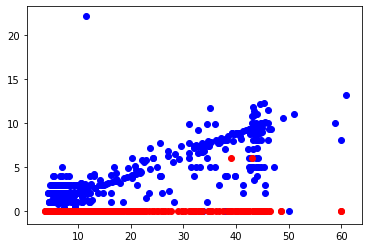

In [21]:
plt.scatter(df[(df['payment_type'] == 'Credit Card')]['fare'].to_numpy(), card_tips, c='b')
plt.scatter(df[(df['payment_type'] == 'Cash')]['fare'].to_numpy(), cash_tips, c='r')
plt.show()

In [22]:
def phi(Y, mu_k, cov_k):
    norm = multivariate_normal(mean=mu_k, cov=cov_k)
    return norm.pdf(Y)

def getExpectation(Y, mu, cov, alpha):
    N = Y.shape[0]
    K = alpha.shape[0]

    gamma = np.mat(np.zeros((N, K)))

    prob = np.zeros((N, K))
    for k in range(K):
        prob[:, k] = phi(Y, mu[k], cov[k])
    prob = np.mat(prob)

    for k in range(K):
        gamma[:, k] = alpha[k] * prob[:, k]
    for i in range(N):
        gamma[i, :] /= np.sum(gamma[i, :])
    return gamma

def maximize(Y, gamma):
    N, D = Y.shape
    K = gamma.shape[1]

    mu = np.zeros((K, D))
    cov = []
    alpha = np.zeros(K)

    for k in range(K):
        Nk = np.sum(gamma[:, k])
        for d in range(D):
            mu[k, d] = np.sum(np.multiply(gamma[:, k], Y[:, d])) / Nk
        cov_k = np.mat(np.zeros((D, D)))
        for i in range(N):
            cov_k += gamma[i, k] * (Y[i] - mu[k]).T * (Y[i] - mu[k]) / Nk
        cov.append(cov_k)
        alpha[k] = Nk / N
    cov = np.array(cov)
    return mu, cov, alpha

def scale_data(Y):
    for i in range(Y.shape[1]):
        max_ = Y[:, i].max()
        min_ = Y[:, i].min()
        Y[:, i] = (Y[:, i] - min_) / (max_ - min_)
    print("Data scaled.")
    return Y

def init_params(shape, K):
    N, D = shape
    mu = np.random.rand(K, D)
    cov = np.array([np.eye(D)] * K)
    alpha = np.array([1.0 / K] * K)
    print("Parameters initialized.")
    print("mu:", mu, "cov:", cov, "alpha:", alpha, sep="\n")
    return mu, cov, alpha
def GMM_EM(Y, K, times):
    Y = scale_data(Y)
    mu, cov, alpha = init_params(Y.shape, K)
    for i in range(times):
        gamma = getExpectation(Y, mu, cov, alpha)
        mu, cov, alpha = maximize(Y, gamma)
    print("{sep} Result {sep}".format(sep="-" * 20))
    print("mu:", mu, "cov:", cov, "alpha:", alpha, sep="\n")
    return mu, cov, alpha


 mu = 2.45 and sigma = 0.67



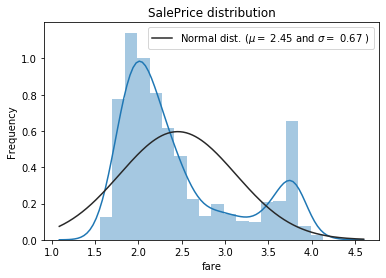

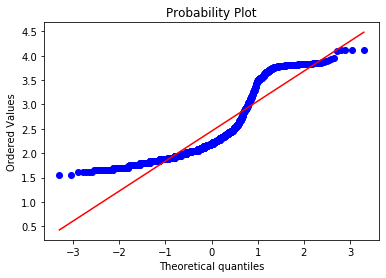

In [23]:
from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
dflog = np.log1p(df["fare"])

#Check the new distribution 
sns.distplot(dflog , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(dflog)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(dflog, plot=plt)
plt.show()

Data scaled.
Parameters initialized.
mu:
[[0.67425775]
 [0.31458002]]
cov:
[[[1.]]

 [[1.]]]
alpha:
[0.5 0.5]
-------------------- Result --------------------
mu:
[[0.78847594]
 [0.19628993]]
cov:
[[[0.01214061]]

 [[0.01256392]]]
alpha:
[0.33159029 0.66840971]


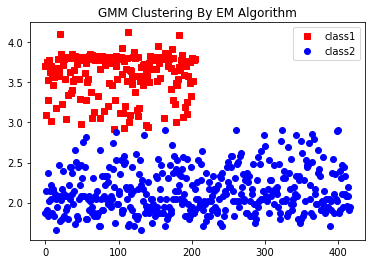

In [24]:
df=df[(df['payment_type'] == 'Credit Card')]
Y = np.log1p(df['fare'])
matY = np.matrix(Y, copy=True).T

Y_m = np.array(Y, copy=True)

K = 2

mu, cov, alpha = GMM_EM(matY, K, 100)

N = Y.shape[0]

gamma = getExpectation(matY, mu, cov, alpha)

category = gamma.argmax(axis=1).flatten().tolist()[0]

class1 = np.array([Y_m[i] for i in range(N) if category[i] == 0])
class2 = np.array([Y_m[i] for i in range(N) if category[i] == 1])


plt.plot(class1, 'rs', label="class1")
plt.plot(class2, 'bo', label="class2")
plt.legend(loc="best")
plt.title("GMM Clustering By EM Algorithm")
plt.show()

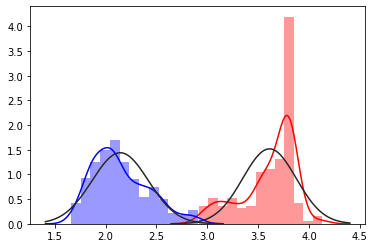

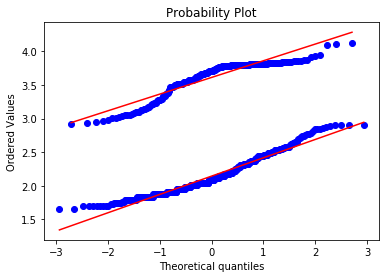

In [25]:
sns.distplot(class1 , fit=norm,color='r');
sns.distplot(class2 , fit=norm,color='b');

fig = plt.figure()
res = stats.probplot(class1, plot=plt)
res = stats.probplot(class2, plot=plt)
plt.show()

In [26]:
df['category']=category

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
fare0=df[df['category'] == 0]['fare'].to_numpy()
tips0=df[df['category'] == 0]['tips'].to_numpy()

fare1=df[df['category'] == 1]['fare'].to_numpy()
tips1=df[df['category'] == 1]['tips'].to_numpy()

In [48]:
fare_train, fare_test, tips_train, tips_test = train_test_split(df.fare, df.tips, test_size=0.1)

In [49]:
Y = fare_train
matY = np.matrix(Y, copy=True).T

K = 2

mu_train, cov_train, alpha_train = GMM_EM(matY, K, 5)

N = Y.shape[0]


gamma = getExpectation(matY, mu_train, cov_train, alpha_train)
category_train = gamma.argmax(axis=1).flatten().tolist()[0]

Data scaled.
Parameters initialized.
mu:
[[0.9256214 ]
 [0.04153368]]
cov:
[[[1.]]

 [[1.]]]
alpha:
[0.5 0.5]
-------------------- Result --------------------
mu:
[[0.38267397]
 [0.11540463]]
cov:
[[[0.08441404]]

 [[0.02256064]]]
alpha:
[0.44735059 0.55264941]


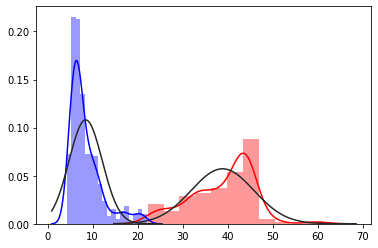

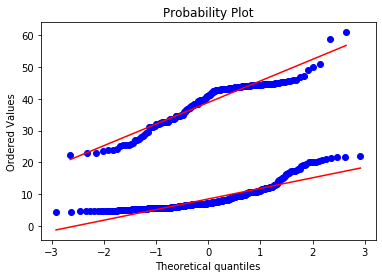

In [50]:
fare_train1 = np.array([fare_train.values[i] for i in range(N) if category_train[i] == 0])
fare_train2 = np.array([fare_train.values[i] for i in range(N) if category_train[i] == 1])

tips_train1 = np.array([tips_train.values[i] for i in range(N) if category_train[i] == 0])
tips_train2 = np.array([tips_train.values[i] for i in range(N) if category_train[i] == 1])


sns.distplot(fare_train1 , fit=norm,color='r');
sns.distplot(fare_train2 , fit=norm,color='b');

fig = plt.figure()
res = stats.probplot(fare_train1, plot=plt)
res = stats.probplot(fare_train2, plot=plt)
plt.show()



In [51]:
Y = fare_test
matY = np.matrix(Y, copy=True).T

matY = scale_data(matY)

N = Y.shape[0]
gamma = getExpectation(matY, mu_train, cov_train, alpha_train)
category_test = gamma.argmax(axis=1).flatten().tolist()[0]

Data scaled.


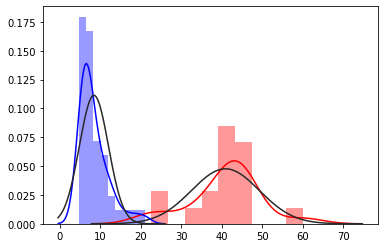

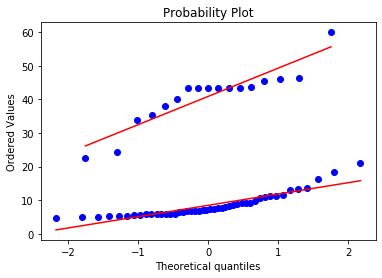

In [52]:
fare_test1 = np.array([fare_test.values[i] for i in range(N) if category_test[i] == 0])
fare_test2 = np.array([fare_test.values[i] for i in range(N) if category_test[i] == 1])

tips_test1 = np.array([tips_test.values[i] for i in range(N) if category_test[i] == 0])
tips_test2 = np.array([tips_test.values[i] for i in range(N) if category_test[i] == 1])

sns.distplot(fare_test1 , fit=norm,color='r');
sns.distplot(fare_test2 , fit=norm,color='b');

fig = plt.figure()
res = stats.probplot(fare_test1, plot=plt)
res = stats.probplot(fare_test2, plot=plt)
plt.show()

In [53]:
train1 = fare_train1.reshape(-1, 1)
train2 = fare_train2.reshape(-1, 1)

In [54]:
test1 = fare_test1.reshape(-1, 1)
test2 = fare_test2.reshape(-1, 1)

In [ ]:
model1=[]
model2=[]
weight=[]

In [55]:
def try_different_method(model,train,tips_train,test):
    model.fit(train, tips_train)
    tips_predict = model.predict(test)
    return tips_predict,model

In [56]:
def try_different_method2(model,train,tips_train,test):
    model.fit(train, tips_train.astype('int'))
    tips_predict = model.predict(test)
    return tips_predict,model



In [57]:
def evaluate():
    tips_test=np.append(tips_test1,tips_test2)
    tips_predict=np.append(tips_predict1,tips_predict2)

    tips_rmse = math.sqrt(mean_squared_error(tips_test, tips_predict))
    tips_r2 = r2_score(tips_test, tips_predict, multioutput='variance_weighted')
    print(tips_rmse)
    print(tips_r2)
    return tips_r2

In [58]:
def evaluate2():
    tips_test=np.append(tips_test1,tips_test2)
    tips_predict=np.append(tips_predict1,tips_predict2)

    tips_rmse = math.sqrt(mean_squared_error(tips_test.astype('int'), tips_predict))
    tips_r2 = r2_score(tips_test.astype('int'), tips_predict, multioutput='variance_weighted')
    print(tips_rmse)
    print(tips_r2)
    return tips_r2


In [59]:
tips_predict1,model = try_different_method(DecisionTreeRegressor(),train1,tips_train1,test1)
model1.append(model)
tips_predict2,model = try_different_method(DecisionTreeRegressor(),train2,tips_train2,test2)
model2.append(model)
score_r2=evaluate()
weight.append(score_r2)

1.7809068930946568
0.6658818072127255


In [60]:
tips_predict1,model = try_different_method(RandomForestRegressor(),train1,tips_train1,test1)
model1.append(model)
tips_predict2,model = try_different_method(RandomForestRegressor(),train2,tips_train2,test2)
model2.append(model)
score_r2=evaluate()
weight.append(score_r2)

1.6438677434216857
0.7153236156513003


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [61]:
tips_predict1,model = try_different_method2(KNeighborsRegressor(n_neighbors=50),train1,tips_train1,test1)
model1.append(model)
tips_predict2,model = try_different_method2(KNeighborsRegressor(n_neighbors=50),train2,tips_train2,test2)
model2.append(model)
score_r2=evaluate()
weight.append(score_r2)

1.489715004170527
0.7360757955294541


In [62]:
tips_predict1,model = try_different_method(svm.SVR(gamma='auto'),train1,tips_train1,test1)
model1.append(model)
tips_predict2 = try_different_method(svm.SVR(gamma='auto'),train2,tips_train2,test2)
model2.append,model(model)
score_r2=evaluate()
weight.append(score_r2)

1.5204605452383078
0.7564612884915476


In [63]:
tips_predict1,model = try_different_method(MLPRegressor(),train1,tips_train1,test1)
model1.append(model)
tips_predict2,model = try_different_method(MLPRegressor(),train2,tips_train2,test2)
model2.append(model)
score_r2=evaluate()
weight.append(score_r2)

1.7688609326800266
0.6703864366891337


In [64]:
tips_predict1,model = try_different_method2(KNeighborsClassifier(n_neighbors=50),train1,tips_train1,test1)
model1.append(model)
tips_predict2,model = try_different_method2(KNeighborsClassifier(n_neighbors=50),train2,tips_train2,test2)
model2.append(model)
score_r2=evaluate()
weight.append(score_r2)

1.5013221686128044
0.7319470246299515


In [65]:
'''tips_predict1 = try_different_method2(DecisionTreeClassifier(),train1,tips_train1,test1)
tips_predict2 = try_different_method2(DecisionTreeClassifier(),train2,tips_train2,test2)
evaluate2()'''

2.3162640965743444
0.36195841073889856


In [66]:
tips_predict1,model = try_different_method2(SVC(gamma='auto'),train1,tips_train1,test1)
model1.append(model)
tips_predict2,model = try_different_method2(SVC(gamma='auto'),train2,tips_train2,test2)
model2.append(model)
score_r2=evaluate()
weight.append(score_r2)

1.5735915849388864
0.7055192664948763


In [67]:
tips_predict1,model = try_different_method(LinearRegression(),train1,tips_train1,test1)
model1.append(model)
tips_predict2,model = try_different_method(LinearRegression(),train2,tips_train2,test2)
model2.append(model)
score_r2=evaluate()
weight.append(score_r2)

1.6243224077962883
0.7220528885839433
